# Patient Survival Detection using NN 🏥👨‍⚕️👩‍⚕️

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.cluster import KMeans
import keras
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.metrics import roc_auc_score, classification_report, roc_curve 
import evidently
import mlflow

import warnings
warnings.filterwarnings('ignore')
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_rows', 250)


In [2]:
# mlflow.set_experiment('BaselineNB')
# mlflow.autolog()

2023/10/12 14:20:51 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.


2023/10/12 14:20:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/10/12 14:20:52 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2023/10/12 14:20:52 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/10/12 14:20:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


## `EDA`
1. Basic Lookup
2. Outlier Detection
3. Multicollinearity Check
4. Target Variable Distribution
5. Bucketisation of Categorical Variables (if any)
6. Column-wise Analysis / Distribution
7. Null Value Treatment

In [43]:
# Load the data
rootdf = pd.read_csv("../Dataset/Dataset.csv") # Dataset
datadict = pd.read_csv("../Dataset/Data Dictionary.csv") # Data Dictionary

In [44]:
rootdf.shape

(91713, 186)

In [45]:
datadict['Category'].value_counts() # Category of the variables in the dataset

Category
labs                         60
vitals                       52
APACHE covariate             28
demographic                  16
labs blood gas               16
APACHE comorbidity            8
identifier                    3
APACHE prediction             2
APACHE grouping               2
GOSSIS example prediction     1
Name: count, dtype: int64

In [46]:
rootdf['hospital_death'].value_counts() # Target variable

hospital_death
0    83798
1     7915
Name: count, dtype: int64

In [6]:
rootdf.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

%Percentages of the null values in each column:

In [47]:
null_val = rootdf.isnull().sum(axis=0) * 100 / rootdf.shape[0]
null_val.sort_values(ascending=False)   

h1_bilirubin_min                 92.265001
h1_bilirubin_max                 92.265001
h1_lactate_max                   91.992411
h1_lactate_min                   91.992411
h1_albumin_max                   91.398166
h1_albumin_min                   91.398166
h1_pao2fio2ratio_min             87.441257
h1_pao2fio2ratio_max             87.441257
h1_arterial_ph_max               83.329517
h1_arterial_ph_min               83.329517
h1_hco3_max                      82.969699
h1_hco3_min                      82.969699
h1_arterial_pco2_min             82.822501
h1_arterial_pco2_max             82.822501
h1_wbc_max                       82.815958
h1_wbc_min                       82.815958
h1_arterial_po2_max              82.807236
h1_arterial_po2_min              82.807236
h1_calcium_max                   82.717826
h1_calcium_min                   82.717826
h1_platelets_max                 82.510658
h1_platelets_min                 82.510658
h1_bun_max                       81.876070
h1_bun_min 

In [48]:
# Find rows with null percentage equal to 50%
rows_with_50_percent_null = null_val[null_val >= 50].count()

print("Number of rows with 50% null values:", rows_with_50_percent_null)

Number of rows with 50% null values: 74


In [6]:
rootdf.describe()

encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.000000     23.641975          0.000000    162.500000   
50%       65.000000     27.654655          0.000000    170.100000   
75%       75.000000     32.930206          0.000000    177.800000   
max       89.000000     67.814990          1.000000    195.590000   

             icu_id  pre_icu_los_days  readmission_status        weight  \
count  91713.000000      91713.000000             91713.0  88993.000000   
mean     508.357692          0.835766                 0.0     84.028340   
std      228.989661          2.487756                 0.0     25.011497   
min       82.000000        -24.947222                 0.0     38.600000   
25%      369.000000          0.035417                 0.0     66.800000   
50%      504.000000          0.138889                 0.0     80.300000   
75%      679.000000          0.409028                 0.0     97.100000   
max      927.000000        159.090972                 0.0    186.000000   

       albumin_apache  apache_2_diagnosis  apache_3j_diagnosis  \
count    37334.000000        90051.000000         90612.000000   
mean         2.902968          185.401739           558.216377   
std          0.681863           86.050882           463.266985   
min          1.200000          101.000000             0.010000   
25%          2.400000          113.000000           203.010000   
50%          2.900000          122.000000           409.020000   
75%          3.400000          301.000000           703.030000   
max          4.600000          308.000000          2201.050000   

       apache_post_operative    arf_apache  bilirubin_apache   bun_apache  \
count           91713.000000  90998.000000      33579.000000  72451.00000   
mean                0.201106      0.027979          1.147721     25.82533   
std                 0.400829      0.164912          2.165538     20.67298   
min                 0.000000      0.000000          0.100000      4.00000   
25%                 0.000000      0.000000          0.400000     13.00000   
50%                 0.000000      0.000000          0.600000     19.00000   
75%                 0.000000      0.000000          1.100000     32.00000   
max                 1.000000      1.000000         51.000000    127.00000   

       creatinine_apache   fio2_apache  gcs_eyes_apache  gcs_motor_apache  \
count       72860.000000  20845.000000     89812.000000      89812.000000   
mean            1.480014      0.595751         3.465049          5.471195   
std             1.525787      0.263238         0.951715          1.288376   
min             0.300000      0.210000         1.000000          1.000000   
25%             0.720000      0.400000         3.000000          6.000000   
50%             0.980000      0.500000         4.000000          6.000000   
75%             1.530000      0.850000         4.000000          6.000000   
max            11.180000      1.000000         4.000000          6.000000   

       gcs_unable_apache  gcs_verbal_apache  glucose_apache  \
count       90676.000000       89812.00000

In [7]:
numerical_feature = [feature for feature in rootdf.columns if rootdf[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(rootdf[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in rootdf.columns if feature not in numerical_feature]

print("Numerical Features Count {}".format(len(numerical_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))

Numerical Features Count 178
Categorical feature Count 8
Discrete feature Count 19
Continuous feature Count 159


>`3` identifier columns can be dropped... + icu_id(demographic) + 'icu_stay_type' + 'hospital_admit_source' + 'icu_admit_source'

> readmission_status is binary and give info about patient's readmission in the same hospital (not useful for survival prediction) dropping it

> dropping all columns with more than 50% null values ( 74 in our case )

> observed corelated variables bmi, weight, height ... need to do something about it

In [49]:
rootdf.drop(['encounter_id','patient_id','hospital_id','icu_id','icu_stay_type','hospital_admit_source','icu_admit_source',"readmission_status"],axis=1,inplace=True)

In [50]:
# Drop columns with more than 50% null values
# Filter columns with null percentage greater than 50%
columns_above_50_percent_null = null_val[null_val > 50].index.tolist()

rootdf.drop(columns_above_50_percent_null, axis=1, inplace=True)

In [51]:
rootdf.shape

(91713, 104)

In [49]:
rootdf.nunique()

hospital_death                       2
age                                 74
bmi                              34888
elective_surgery                     2
ethnicity                            6
gender                               2
height                             401
icu_type                             8
pre_icu_los_days                  9757
weight                            3409
apache_2_diagnosis                  44
apache_3j_diagnosis                399
apache_post_operative                2
arf_apache                           2
bun_apache                         476
creatinine_apache                 1127
gcs_eyes_apache                      4
gcs_motor_apache                     6
gcs_unable_apache                    2
gcs_verbal_apache                    5
glucose_apache                     565
heart_rate_apache                  149
hematocrit_apache                  353
intubated_apache                     2
map_apache                         161
resprate_apache          

**Removing missing values from some of the inter-related columns (bmi, weight and height)**
We cut down almost 3000 instances with this process safely::: 

In [52]:
# Removing the rows where there are missing values in "at least one" of the columns 'bmi', 'weight', or 'height'.
rootdf = rootdf[rootdf[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0] 

In [53]:
rootdf.shape

(88284, 104)

#### EDA - for large dataset
Individual plots dosen't make much sense for large dataset...

General Plots for overall insights

Target Variable (hospital_death):
* What is the distribution of the target variable (hospital_death)? Is it imbalanced?
* Are there any missing values in the target variable?

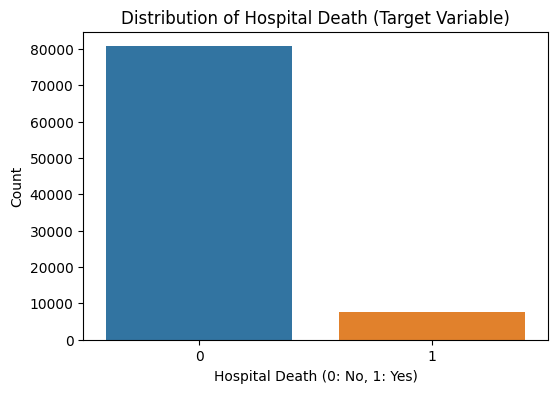

In [15]:
y = rootdf['hospital_death']
# TODO: Plot Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=rootdf, x='hospital_death')
plt.title('Distribution of Hospital Death (Target Variable)')
plt.xlabel('Hospital Death (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

In [17]:
# Percentage of the distribution of the target variable
percentage_distribution = rootdf['hospital_death'].value_counts(normalize=True) * 100
print("Percentage Distribution of the Target Variable:\n", percentage_distribution)

Percentage Distribution of the Target Variable:
 0    91.445789
1     8.554211
Name: hospital_death, dtype: float64


In [18]:
rootdf['hospital_death'].isna().sum()

0

In [19]:
rootdf["hospital_death"].isna().sum()

0

Demographics:

* How is age distributed among patients who survived and those who didn't?
* What is the gender distribution of patients in the dataset?
* Are there any differences in survival based on gender?
* How does ethnicity relate to patient outcomes?

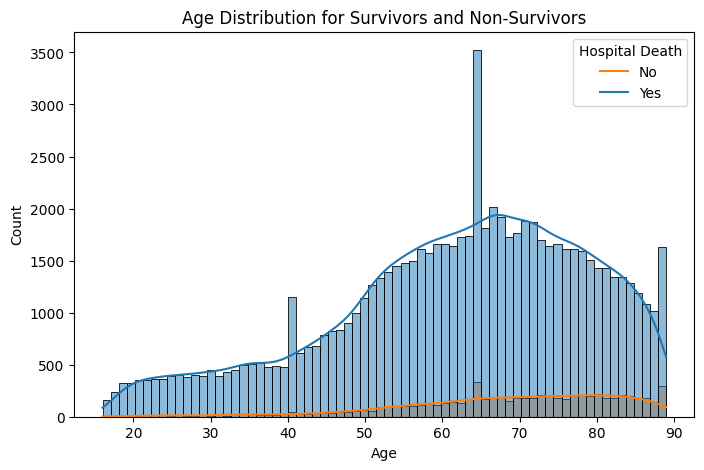

In [22]:
#1
plt.figure(figsize=(8, 5))
sns.histplot(data=rootdf, x='age', hue='hospital_death', kde=True)
plt.title('Age Distribution for Survivors and Non-Survivors')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Hospital Death', labels=['No', 'Yes'])
plt.show()

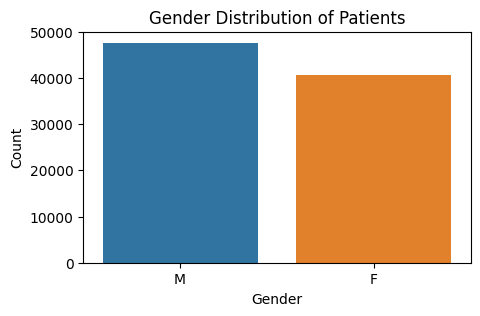

In [24]:
#2
plt.figure(figsize=(5, 3))
sns.countplot(data=rootdf, x='gender')
plt.title('Gender Distribution of Patients')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

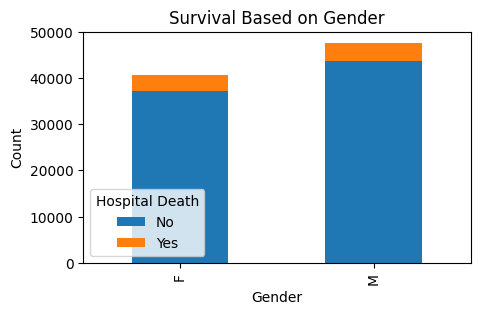

In [27]:
gender_survival = rootdf.groupby(['gender', 'hospital_death']).size().unstack()
gender_survival.plot(kind='bar', stacked=True, figsize=(5, 3))
plt.title('Survival Based on Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Hospital Death', labels=['No', 'Yes'])
plt.show()

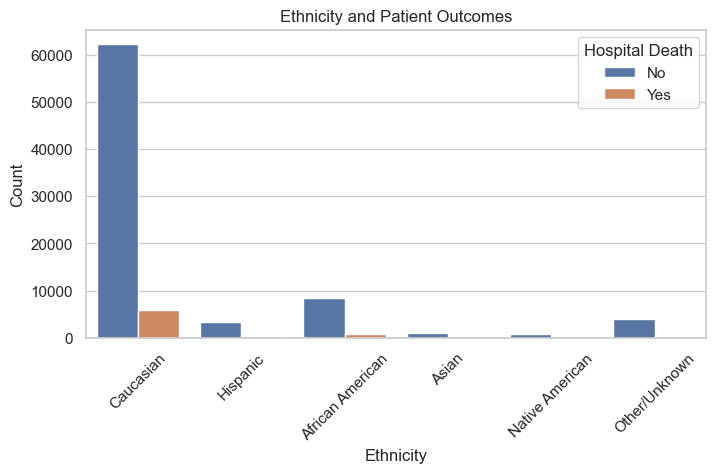

In [34]:
plt.figure(figsize=(8, 4))
sns.countplot(data=rootdf, x='ethnicity', hue='hospital_death')
plt.title('Ethnicity and Patient Outcomes')
plt.xlabel('Ethnicity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hospital Death', labels=['No', 'Yes'])
plt.show()

Clinical Metrics:

* What is the distribution of BMI (body mass index) among patients?
* Do patients with elective surgery have different survival rates?
* How do pre-ICU length of stay (pre_icu_los_days) and weight vary among patients who survived and those who didn't?

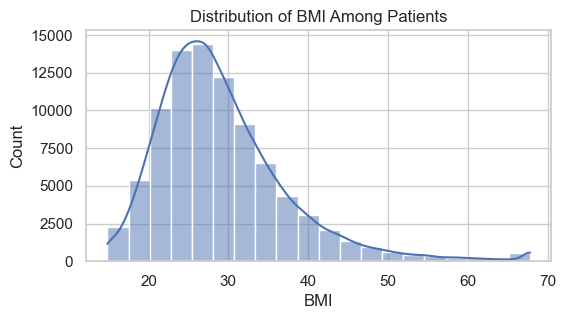

In [39]:
plt.figure(figsize=(6, 3))
sns.histplot(data=rootdf, x='bmi', bins=20, kde=True)
plt.title('Distribution of BMI Among Patients')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

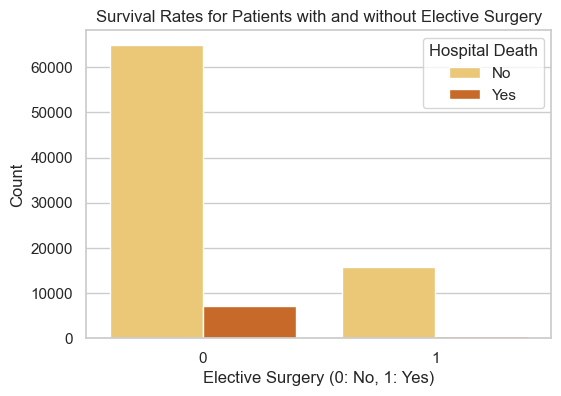

In [53]:
plt.figure(figsize=(6, 4))
sns.countplot(data=rootdf, x='elective_surgery', hue='hospital_death', palette="YlOrBr")
plt.title('Survival Rates for Patients with and without Elective Surgery')
plt.xlabel('Elective Surgery (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Hospital Death', labels=['No', 'Yes'])
plt.show()

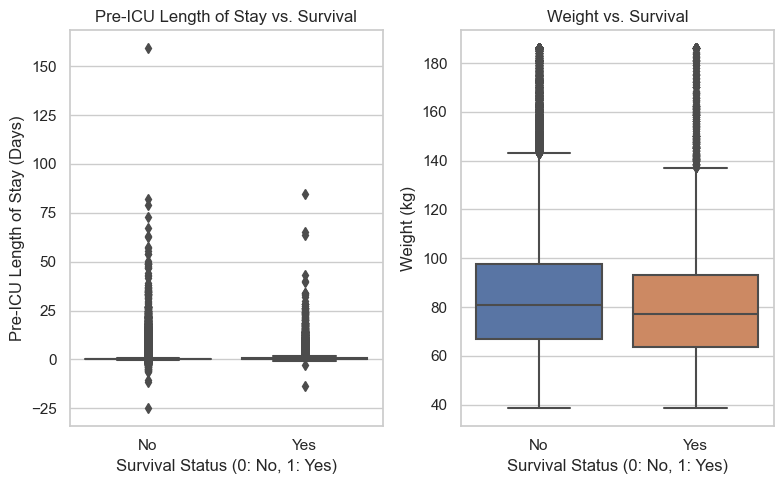

In [52]:
plt.figure(figsize=(8, 5))

# Plot 1: Pre-ICU Length of Stay vs. Survival
plt.subplot(1, 2, 1)
sns.boxplot(data=rootdf, x='hospital_death', y='pre_icu_los_days')
plt.title('Pre-ICU Length of Stay vs. Survival')
plt.xlabel('Survival Status (0: No, 1: Yes)')
plt.ylabel('Pre-ICU Length of Stay (Days)')
plt.xticks([0, 1], ['No', 'Yes'])  # Adjust x-axis labels

# Plot 2: Weight vs. Survival
plt.subplot(1, 2, 2)
sns.boxplot(data=rootdf, x='hospital_death', y='weight')
plt.title('Weight vs. Survival')
plt.xlabel('Survival Status (0: No, 1: Yes)')
plt.ylabel('Weight (kg)')
plt.xticks([0, 1], ['No', 'Yes'])  # Adjust x-axis labels

plt.tight_layout()
plt.show()

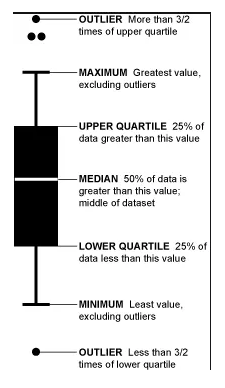

Diagnoses:

* Explore the distribution of apache_2_diagnosis and apache_3j_diagnosis.
* Do certain diagnoses have higher mortality rates?
* Does the presence of post-operative patients (apache_post_operative) impact survival?

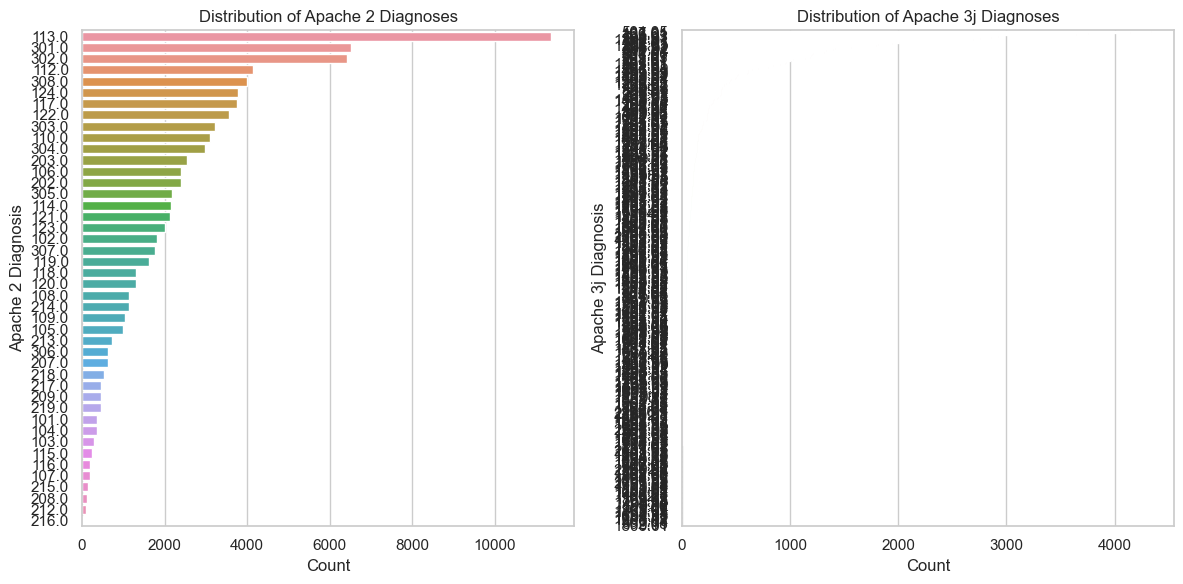

In [55]:
plt.figure(figsize=(12, 6))

# Plot 1: Distribution of apache_2_diagnosis
plt.subplot(1, 2, 1)
sns.countplot(data=rootdf, y='apache_2_diagnosis', orient='h', order=rootdf['apache_2_diagnosis'].value_counts().index)
plt.title('Distribution of Apache 2 Diagnoses')
plt.xlabel('Count')
plt.ylabel('Apache 2 Diagnosis')

# Plot 2: Distribution of apache_3j_diagnosis
plt.subplot(1, 2, 2)
sns.countplot(data=rootdf, y='apache_3j_diagnosis', orient='h', order=rootdf['apache_3j_diagnosis'].value_counts().index)
plt.title('Distribution of Apache 3j Diagnoses')
plt.xlabel('Count')
plt.ylabel('Apache 3j Diagnosis')

plt.tight_layout()
plt.show()

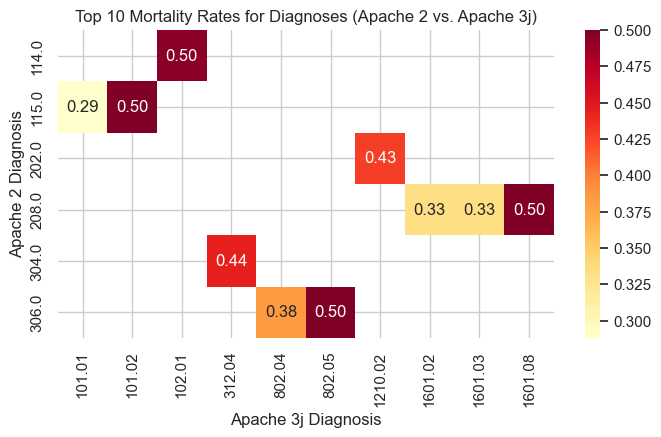

In [58]:
# Group the data by diagnosis and calculate the average hospital_death rate for each diagnosis
diagnosis_mortality = rootdf.groupby(['apache_2_diagnosis', 'apache_3j_diagnosis'])['hospital_death'].mean().reset_index()

# Determine the top N Apache 3j diagnoses by highest average mortality rates
top_n = 10  # Adjust as needed
top_diagnoses = diagnosis_mortality.groupby('apache_3j_diagnosis')['hospital_death'].mean().nlargest(top_n).index

# Filter the data for the top N diagnoses
filtered_mortality_heatmap = diagnosis_mortality[diagnosis_mortality['apache_3j_diagnosis'].isin(top_diagnoses)]

# Pivot the filtered table for the heatmap
filtered_mortality_heatmap_pivot = filtered_mortality_heatmap.pivot('apache_2_diagnosis', 'apache_3j_diagnosis', 'hospital_death')

plt.figure(figsize=(8, 4))
sns.heatmap(data=filtered_mortality_heatmap_pivot, cmap='YlOrRd', annot=True, fmt='.2f', cbar=True)
plt.title(f'Top {top_n} Mortality Rates for Diagnoses (Apache 2 vs. Apache 3j)')
plt.xlabel('Apache 3j Diagnosis')
plt.ylabel('Apache 2 Diagnosis')
plt.show()

The color (hue) represents the average hospital death rate for different combinations of Apache 2 diagnoses and Apache 3j diagnoses. The color intensity indicates the magnitude of this rate, and it ranges from 0.3 to 0.5.

Here's how to interpret the color (hue) in the heatmap:

Darker colors (e.g., deep red) represent higher average hospital death rates.
Lighter colors (e.g., pale yellow) represent lower average hospital death rates.

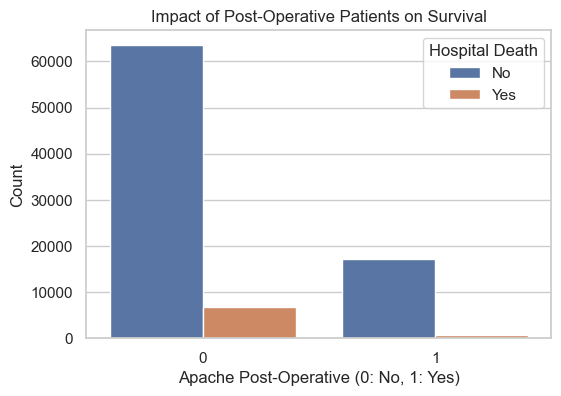

In [59]:
plt.figure(figsize=(6, 4))
sns.countplot(data=rootdf, x='apache_post_operative', hue='hospital_death')
plt.title('Impact of Post-Operative Patients on Survival')
plt.xlabel('Apache Post-Operative (0: No, 1: Yes)')
plt.ylabel('Count')
plt.legend(title='Hospital Death', labels=['No', 'Yes'])
plt.show() 
# This plot compares the survival rates for patients who were post-operative (1) and those who were not (0).

We can analyse further by answering the following questions:<br>

>Clinical Scores and Readings:

* Analyze the distribution of scores like apache_4a_hospital_death_prob and apache_4a_icu_death_prob.
* How do vital signs like heart rate, respiratory rate, and blood pressure (e.g., d1_heartrate_max, d1_resprate_max, d1_sysbp_max) differ between   survivors and non-survivors?

>Lab Results:

* Investigate the distribution of lab results such as creatinine, glucose, and sodium levels.
* Are there differences in these levels for patients who survived and those who didn't?

>Intubation and Ventilation:

* Explore the intubated_apache and ventilated_apache columns.
* Do patients who required intubation or ventilation have higher mortality rates?

>Time Series Analysis:

* How do vital signs (e.g., heart rate, blood pressure) change over time within the first day of admission (d1_) and within the first hour of admission (h1_) for survivors and non-survivors?

>Comorbidities:

* Investigate the presence of comorbidities like AIDS, cirrhosis, diabetes mellitus, etc.
* Do patients with certain comorbidities have different survival rates?

> Body Systems:

* Explore the apache_3j_bodysystem and apache_2_bodysystem columns.
* How does the affected body system relate to patient outcomes?

### Multivariate Analysis 

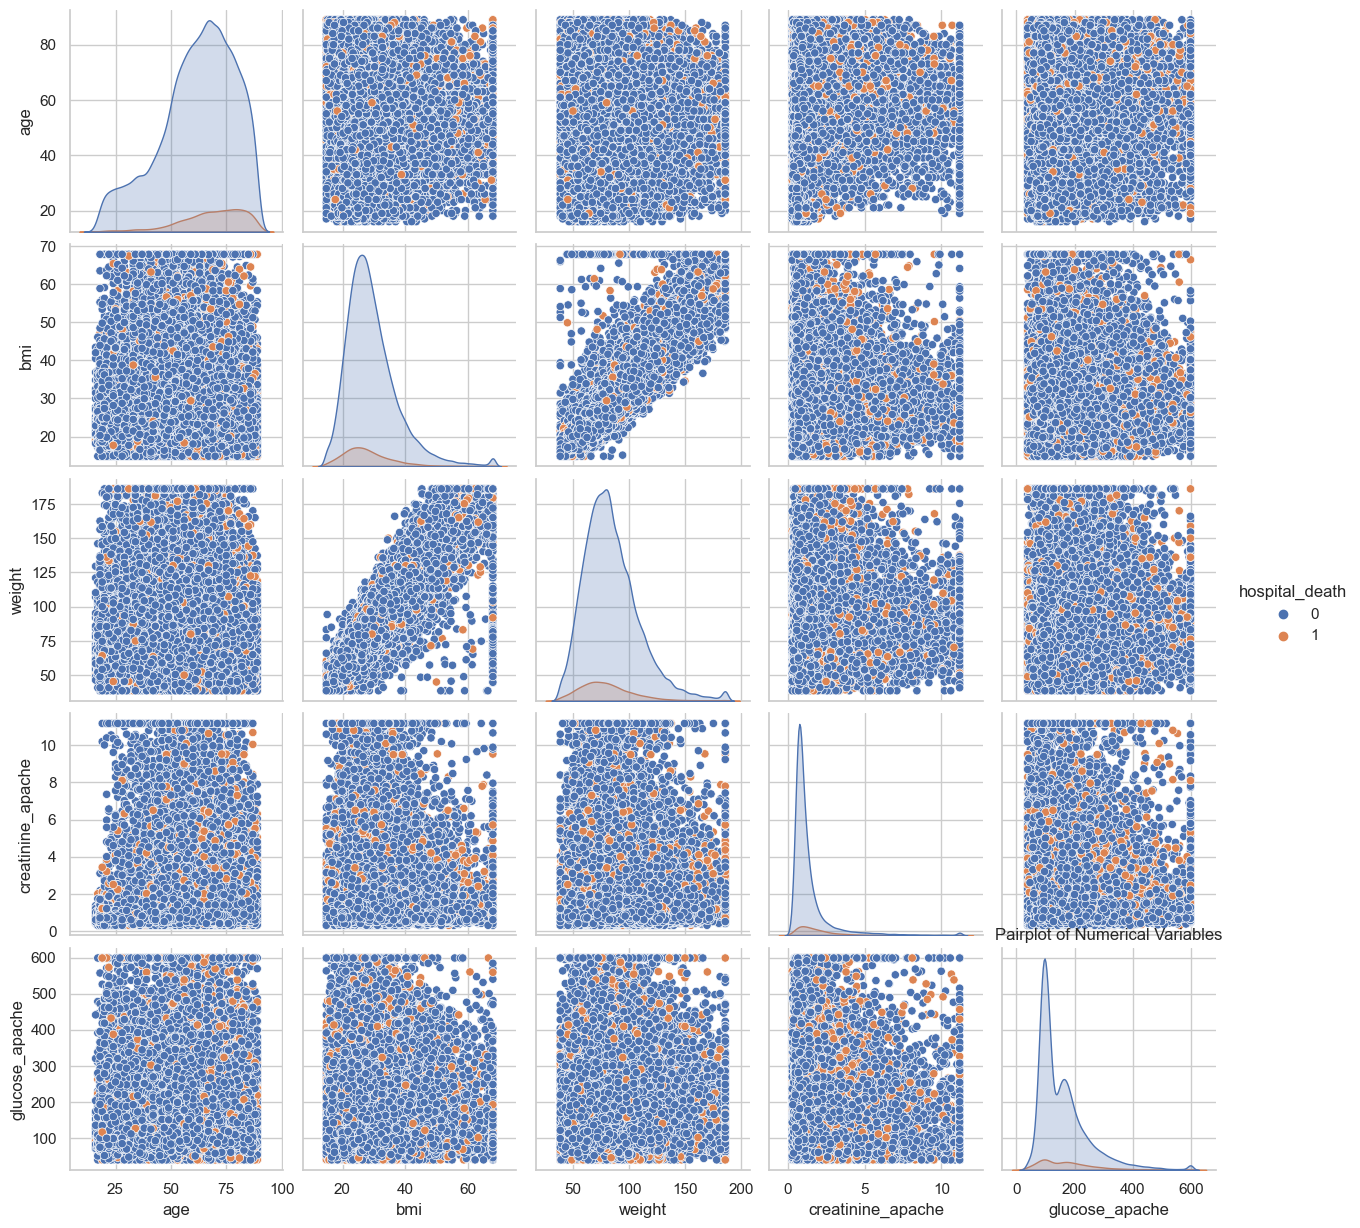

In [61]:
sns.pairplot(rootdf[['age', 'bmi', 'weight', 'creatinine_apache', 'glucose_apache', 'hospital_death']], hue='hospital_death')
plt.title('Pairplot of Numerical Variables')
plt.show()

In [64]:
## Should NOT contain NAN values...
kmeans = KMeans(n_clusters=3)
rootdf['cluster'] = kmeans.fit_predict(rootdf[['age', 'bmi', 'weight', 'creatinine_apache', 'glucose_apache']])
sns.pairplot(rootdf[['age', 'bmi', 'weight', 'creatinine_apache', 'glucose_apache', 'cluster']], hue='cluster')
plt.title('Pairplot with Clusters')
plt.show()

# ValueError: Input X contains NaN.

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

*Kmeans dosent handle null values so we need to impute them first*

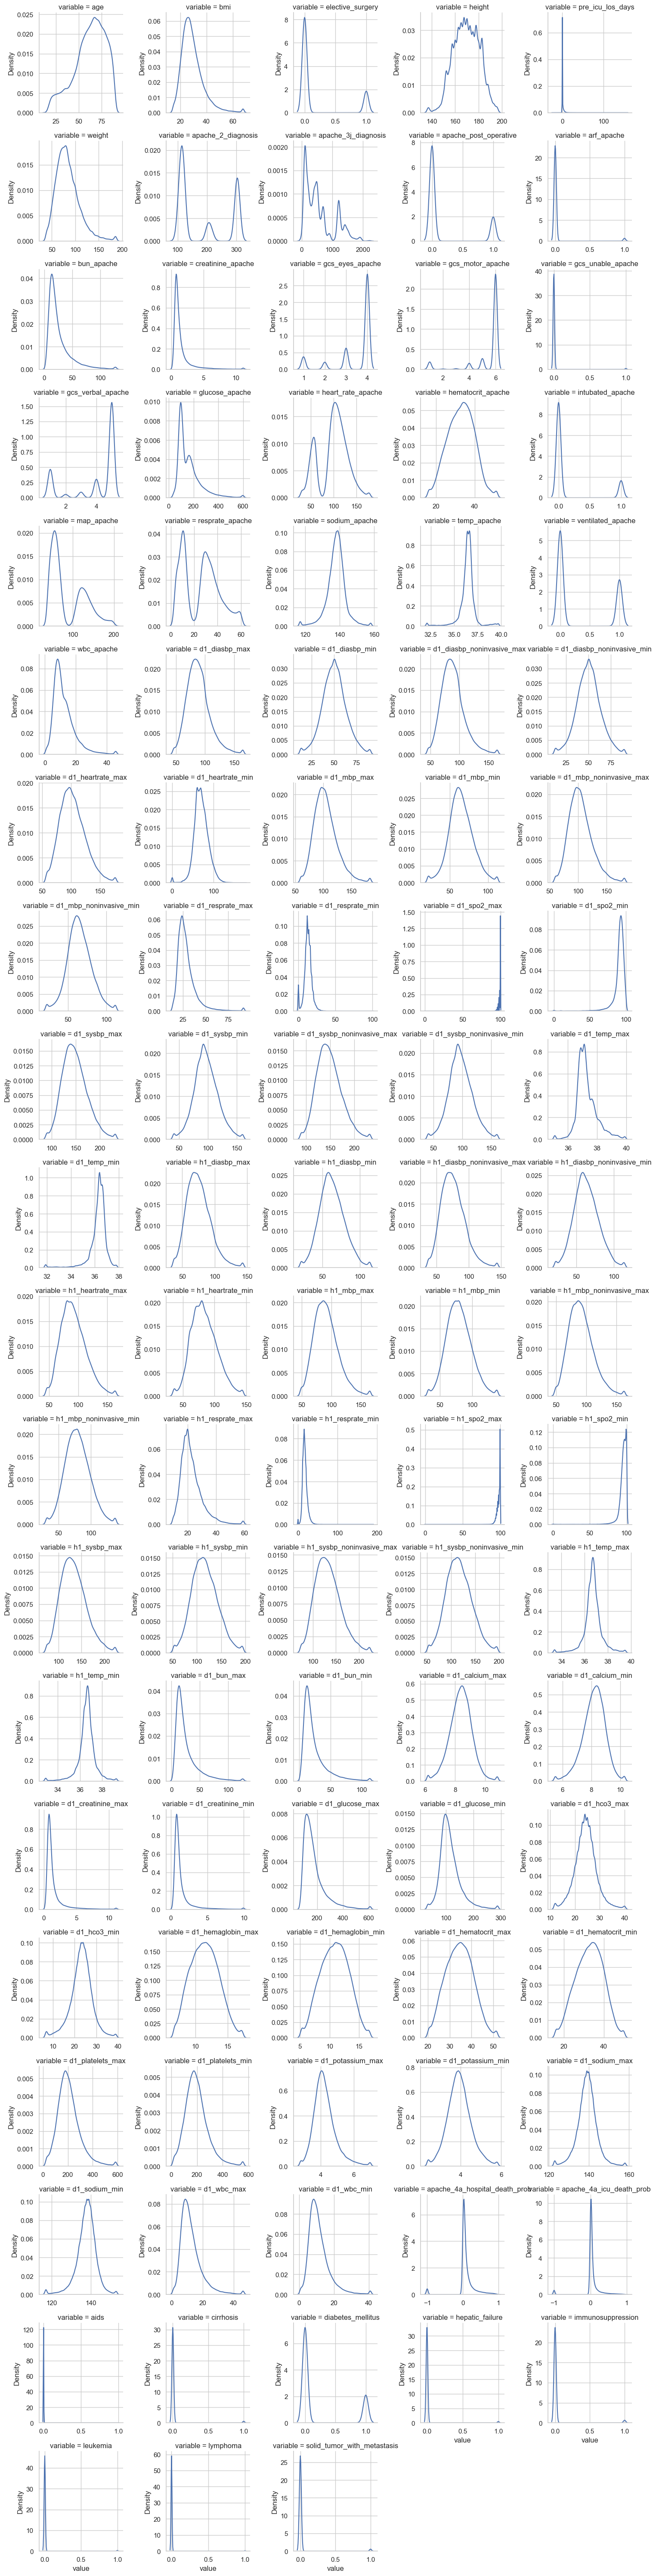

In [65]:
# Create a set of facetted kernel density estimation (KDE) plots using Seaborn's FacetGrid for all numerical variables
unpivot = pd.melt(rootdf, rootdf.describe().columns[0], rootdf.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=5, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

can explore: IQR based outlier detection and removal

### Ydata Profiling 

In [11]:
from ydata_profiling import ProfileReport

In [12]:
# profile = ProfileReport(rootdf, title="Hospital Profiling Report", explorative=True)
profile = ProfileReport(rootdf, title="Hospital Profiling Report", minimal=True)

In [26]:
profile.to_file("Hospital Profiling Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Export report to file: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


In [14]:
profile.to_file("Hospital Profiling Minimal Report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

***

## Observations:

* <b>Need to handle `(IMPUTE) `missing values as we will be training Neural Networks which are not robust to missing values</b>

* <b>`Ethnicity` column can be dropped as the data is highly skewed and ethnicity would not help in predicting death of a paitent(subjective approach)</b>

* <b> Most Deaths recorded wrt age: 60-70 & 85-90</b>

## `Data Preprocessing`
1. Missing Value Treatment
2. Outlier Treatment
3. Intuative Feature Dropping (if any)
4. Imbalanced Data Handling (Dependant variable)
5. Splitting into Train and Test

In [11]:
# removing ethnicity column 
rootdf.drop("ethnicity", axis=1, inplace=True)

In [16]:
rootdf.isnull().sum().sort_values(ascending=False)

wbc_apache                       21063
h1_temp_min                      20833
h1_temp_max                      20833
hematocrit_apache                19005
bun_apache                       18289
creatinine_apache                17926
sodium_apache                    17644
d1_hco3_min                      14390
d1_hco3_max                      14390
d1_platelets_max                 12767
d1_platelets_min                 12767
d1_wbc_max                       12501
d1_wbc_min                       12501
d1_calcium_max                   12315
d1_calcium_min                   12315
d1_hemaglobin_max                11519
d1_hemaglobin_min                11519
d1_hematocrit_min                11051
d1_hematocrit_max                11051
glucose_apache                   10473
d1_bun_min                        9860
d1_bun_max                        9860
d1_creatinine_min                 9561
d1_creatinine_max                 9561
d1_sodium_max                     9554
d1_sodium_min            

In [18]:
# we will use knn imputer to impute the missing values for numerical columns
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")


In [21]:
numerical_feats = [feature for feature in rootdf.columns if rootdf[feature].dtypes != 'O']
categorical_feats = [feature for feature in rootdf.columns if feature not in numerical_feats]

* <b> Important thing to note is there are numerical columns which have discrete categories in it!</b>

In [23]:
rootdf.nunique()[rootdf.nunique() == 2].index.tolist() # Binary features

['hospital_death',
 'elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [ ]:
num_cat = ['elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical_feats = ['gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']

<p style="color:yellow;font-size:25px;">We will use knn imputer on numerical features and mode imputer on categorical features</p> 

In [25]:
# columns with missing values in numerical columns
num_cols_with_missing_values = [col for col in numerical_feats if rootdf[col].isnull().sum() > 0]
num_cols_with_missing_values

['age',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'arf_apache',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_unable_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'ventilated_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_

In [27]:
# columns with missing values in categorical columns
cat_cols_with_missing_values = [col for col in categorical_feats if rootdf[col].isnull().sum() > 0]
cat_cols_with_missing_values

['gender', 'apache_3j_bodysystem', 'apache_2_bodysystem']

In [28]:
rootdf.shape

(88284, 103)

In [29]:
# imputing missing values in numerical columns KNN imputer
rootdf[num_cols_with_missing_values] = imputer.fit_transform(rootdf[num_cols_with_missing_values])

In [31]:
# imputing missing values in categorical columns with mode
rootdf[cat_cols_with_missing_values] = rootdf[cat_cols_with_missing_values].fillna(rootdf[cat_cols_with_missing_values].mode().iloc[0])

In [35]:
rootdf.isna().sum()

hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
gender                           0
height                           0
icu_type                         0
pre_icu_los_days                 0
weight                           0
apache_2_diagnosis               0
apache_3j_diagnosis              0
apache_post_operative            0
arf_apache                       0
bun_apache                       0
creatinine_apache                0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache                       0
resprate_apache                  0
sodium_apache                    0
temp_apache                      0
ventilated_apache                0
wbc_apache          

In [36]:
rootdf.isnull().sum()

hospital_death                   0
age                              0
bmi                              0
elective_surgery                 0
gender                           0
height                           0
icu_type                         0
pre_icu_los_days                 0
weight                           0
apache_2_diagnosis               0
apache_3j_diagnosis              0
apache_post_operative            0
arf_apache                       0
bun_apache                       0
creatinine_apache                0
gcs_eyes_apache                  0
gcs_motor_apache                 0
gcs_unable_apache                0
gcs_verbal_apache                0
glucose_apache                   0
heart_rate_apache                0
hematocrit_apache                0
intubated_apache                 0
map_apache                       0
resprate_apache                  0
sodium_apache                    0
temp_apache                      0
ventilated_apache                0
wbc_apache          

In [37]:
# rootdf.to_csv("processed_null_data.csv", index=False)

---

## \# checkpoint __________________________________

In [54]:
null_treated = pd.read_csv("../Dataset/processed_null_data.csv") # Check the path while running....

In [55]:
null_treated.shape

(88284, 103)

#### Spliting Data

In [56]:
y = null_treated['hospital_death']
X = null_treated.drop('hospital_death', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42,stratify=y)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70627, 102), (17657, 102), (70627,), (17657,))

#### Encoding Features

* SiDE note: HERE multiple ways are available to encoding the discrete numerical features listed above! `(Re-visit Point)` *

In [58]:
categorical_feats = ['gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem'] 
numerical_feats = [feature for feature in X_train.columns if feature not in categorical_feats]

In [59]:
len(categorical_feats), len(numerical_feats)

(4, 98)

In [60]:
def custom_combiner(feature, category):
    return str(feature) + '~' + str(category)   

In [61]:
# One hot encoding for categorical variables
ohe = OneHotEncoder(sparse_output=False,feature_name_combiner=custom_combiner)

In [62]:
X_train_enc = ohe.fit_transform(X_train[categorical_feats])
ohe.get_feature_names_out()

array(['gender~F', 'gender~M', 'icu_type~CCU-CTICU', 'icu_type~CSICU',
       'icu_type~CTICU', 'icu_type~Cardiac ICU', 'icu_type~MICU',
       'icu_type~Med-Surg ICU', 'icu_type~Neuro ICU', 'icu_type~SICU',
       'apache_3j_bodysystem~Cardiovascular',
       'apache_3j_bodysystem~Gastrointestinal',
       'apache_3j_bodysystem~Genitourinary',
       'apache_3j_bodysystem~Gynecological',
       'apache_3j_bodysystem~Hematological',
       'apache_3j_bodysystem~Metabolic',
       'apache_3j_bodysystem~Musculoskeletal/Skin',
       'apache_3j_bodysystem~Neurological',
       'apache_3j_bodysystem~Respiratory', 'apache_3j_bodysystem~Sepsis',
       'apache_3j_bodysystem~Trauma',
       'apache_2_bodysystem~Cardiovascular',
       'apache_2_bodysystem~Gastrointestinal',
       'apache_2_bodysystem~Haematologic',
       'apache_2_bodysystem~Metabolic', 'apache_2_bodysystem~Neurologic',
       'apache_2_bodysystem~Renal/Genitourinary',
       'apache_2_bodysystem~Respiratory', 'apache_2_bod

In [63]:
ohe.get_feature_names_out()

array(['gender~F', 'gender~M', 'icu_type~CCU-CTICU', 'icu_type~CSICU',
       'icu_type~CTICU', 'icu_type~Cardiac ICU', 'icu_type~MICU',
       'icu_type~Med-Surg ICU', 'icu_type~Neuro ICU', 'icu_type~SICU',
       'apache_3j_bodysystem~Cardiovascular',
       'apache_3j_bodysystem~Gastrointestinal',
       'apache_3j_bodysystem~Genitourinary',
       'apache_3j_bodysystem~Gynecological',
       'apache_3j_bodysystem~Hematological',
       'apache_3j_bodysystem~Metabolic',
       'apache_3j_bodysystem~Musculoskeletal/Skin',
       'apache_3j_bodysystem~Neurological',
       'apache_3j_bodysystem~Respiratory', 'apache_3j_bodysystem~Sepsis',
       'apache_3j_bodysystem~Trauma',
       'apache_2_bodysystem~Cardiovascular',
       'apache_2_bodysystem~Gastrointestinal',
       'apache_2_bodysystem~Haematologic',
       'apache_2_bodysystem~Metabolic', 'apache_2_bodysystem~Neurologic',
       'apache_2_bodysystem~Renal/Genitourinary',
       'apache_2_bodysystem~Respiratory', 'apache_2_bod

In [64]:
X_test_enc = ohe.fit_transform(X_test[categorical_feats])

In [65]:
ohe.categories_

[array(['F', 'M'], dtype=object),
 array(['CCU-CTICU', 'CSICU', 'CTICU', 'Cardiac ICU', 'MICU',
        'Med-Surg ICU', 'Neuro ICU', 'SICU'], dtype=object),
 array(['Cardiovascular', 'Gastrointestinal', 'Genitourinary',
        'Gynecological', 'Hematological', 'Metabolic',
        'Musculoskeletal/Skin', 'Neurological', 'Respiratory', 'Sepsis',
        'Trauma'], dtype=object),
 array(['Cardiovascular', 'Gastrointestinal', 'Haematologic', 'Metabolic',
        'Neurologic', 'Renal/Genitourinary', 'Respiratory', 'Trauma',
        'Undefined Diagnoses', 'Undefined diagnoses'], dtype=object)]

In [66]:
ohe.get_feature_names_out()

array(['gender~F', 'gender~M', 'icu_type~CCU-CTICU', 'icu_type~CSICU',
       'icu_type~CTICU', 'icu_type~Cardiac ICU', 'icu_type~MICU',
       'icu_type~Med-Surg ICU', 'icu_type~Neuro ICU', 'icu_type~SICU',
       'apache_3j_bodysystem~Cardiovascular',
       'apache_3j_bodysystem~Gastrointestinal',
       'apache_3j_bodysystem~Genitourinary',
       'apache_3j_bodysystem~Gynecological',
       'apache_3j_bodysystem~Hematological',
       'apache_3j_bodysystem~Metabolic',
       'apache_3j_bodysystem~Musculoskeletal/Skin',
       'apache_3j_bodysystem~Neurological',
       'apache_3j_bodysystem~Respiratory', 'apache_3j_bodysystem~Sepsis',
       'apache_3j_bodysystem~Trauma',
       'apache_2_bodysystem~Cardiovascular',
       'apache_2_bodysystem~Gastrointestinal',
       'apache_2_bodysystem~Haematologic',
       'apache_2_bodysystem~Metabolic', 'apache_2_bodysystem~Neurologic',
       'apache_2_bodysystem~Renal/Genitourinary',
       'apache_2_bodysystem~Respiratory', 'apache_2_bod

In [67]:
len(ohe.get_feature_names_out())

31

4 Categorical Variables were encoded into 31 columns using OneHotEncoder

In [16]:
# Pickle the encoder
# pickle.dump(ohe, open("../Model/ohe_for~cat.pkl", "wb"))

Need to convert `numpy array` to `dataframe`

In [68]:
X_train_enc = pd.DataFrame(X_train_enc, columns=ohe.get_feature_names_out())
X_test_enc = pd.DataFrame(X_test_enc, columns=ohe.get_feature_names_out())

In [69]:
# Join the encoded categorical features with numerical features
X_Train = pd.concat([X_train_enc, X_train[numerical_feats].reset_index(drop=True)], axis=1, ignore_index=True)
X_Test = pd.concat([X_test_enc, X_test[numerical_feats].reset_index(drop=True)], axis=1, ignore_index=True)

98 numerical + 31 categorical encoded = 129 features

In [70]:
X_Train.shape, X_Test.shape

((70627, 129), (17657, 129))

<div style="background-color: orange; color: blue"> TroubleShooted Error!: reset_index()<br>
Apparently while we select features from a dataframe it also copies the indices of the associated rows with it <br>
Hence when we try to `concat` it , it messes up with THE merging... and creates NaN values! <br>
<b>Important Lesson Learned</b></div>

In [73]:
X_Train.columns = ohe.get_feature_names_out().tolist() + numerical_feats
X_Test.columns = ohe.get_feature_names_out().tolist() + numerical_feats
final_cols = X_Train.columns.tolist()

#### Handling Imbalanced Target Variable

In [21]:
null_treated['hospital_death'].value_counts()   

hospital_death
0    80732
1     7552
Name: count, dtype: int64

In [22]:
counter = Counter(y_train)
for k,v in counter.items():                            # Train data
    per = 100*v/len(y_train)
    print(f"Class = {k}, Count = {v} ({per:.2f}%)")

Class = 1, Count = 6042 (8.55%)
Class = 0, Count = 64585 (91.45%)


In [23]:
counter = Counter(y_test)
for k,v in counter.items():
    per = 100*v/len(y_test)                            # Test data
    print(f"Class = {k}, Count = {v} ({per:.2f}%)")

Class = 0, Count = 16147 (91.45%)
Class = 1, Count = 1510 (8.55%)


* **Benifit of using `stratify=y` while splitting data is that it will maintain the ratio of the target variable in both train and test data**

In [26]:
# SMOTE + Tomek links 
smkt = SMOTETomek(random_state=42)
X_res_train, y_res_train = smkt.fit_resample(X_Train, y_train)
X_res_test, y_res_test = smkt.fit_resample(X_Test, y_test)

In [32]:
X_res_train.shape, y_res_train.shape, X_res_test.shape, y_res_test.shape

((129158, 129), (129158,), (32290, 129), (32290,))

In [29]:
counter = Counter(y_res_test)
for k,v in counter.items():
    per = 100*v/len(y_res_test)                            # Test data
    print(f"Class = {k}, Count = {v} ({per:.2f}%)")

Class = 0, Count = 16145 (50.00%)
Class = 1, Count = 16145 (50.00%)


In [30]:
counter = Counter(y_res_train)
for k,v in counter.items():
    per = 100*v/len(y_res_train)                            # Test data
    print(f"Class = {k}, Count = {v} ({per:.2f}%)")

Class = 1, Count = 64579 (50.00%)
Class = 0, Count = 64579 (50.00%)


Imbalance Removed using `SMOTE` (Synthetic Minority Oversampling Technique) + `Tomek Links`

## \# checkpoint________

In [33]:
# Save the data to csv file
# X_res_train.to_csv("../Dataset/X_resampled_train.csv", index=False)
# y_res_train.to_csv("../Dataset/y_resampled_train.csv", index=False)
# X_res_test.to_csv("../Dataset/X_resampled_test.csv", index=False)
# y_res_test.to_csv("../Dataset/y_resampled_test.csv", index=False)

In [3]:
# load the data
X_res_train = pd.read_csv("../Dataset/X_resampled_train.csv")
y_res_train = pd.read_csv("../Dataset/y_resampled_train.csv")
X_res_test = pd.read_csv("../Dataset/X_resampled_test.csv")
y_res_test = pd.read_csv("../Dataset/y_resampled_test.csv")

In [4]:
# Reshape the target variable
y_res_train = y_res_train.values.reshape(-1,)
y_res_test = y_res_test.values.reshape(-1,)

In [5]:
X_res_train.shape, y_res_train.shape, X_res_test.shape, y_res_test.shape

((129158, 129), (129158,), (32290, 129), (32290,))

In [6]:
# RENAMING for convenience
X_Test, y_Test = X_res_test, y_res_test
X_Test.shape, y_Test.shape

((32290, 129), (32290,))

In [7]:
# Splitting for Validation SET and RENAMING for convenience
X_Train, X_Val, y_Train, y_Val = train_test_split(X_res_train, y_res_train, test_size=0.2, random_state=42, stratify=y_res_train)
X_Train.shape, X_Val.shape, y_Train.shape, y_Val.shape

((103326, 129), (25832, 129), (103326,), (25832,))

* **Train | Val | Test Split Ratio = 70:15:15 Approx**

## `Baseline ` <div style="background-color: grey; color: blue"><b>Neural Network</b></div> ` Model`


In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import AUC
import tensorflow as tf

---

#### Simple Architecture

Initial Model: **129 features -> 2 hidden layers (64,32) -> 1 output layer (1)**

In [9]:
model = Sequential()
# Input Layer
model.add(Dense(128, input_dim=129, activation='relu'))
# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [10]:
# Compile the model with adam optimizer and binary cross entropy loss function
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])

In [11]:
# Fit the model
history = model.fit(X_Train, y_Train, validation_data=(X_Val, y_Val), epochs=100, batch_size=64)

2023/10/08 18:19:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '41a65789186040cd8e5606aa5db1ee52', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/10/08 18:19:46 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2023/10/08 18:19:46 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
1615/1615 [==============================] - 6s 3ms/step - loss: 0.6782 - accuracy: 0.7266 - auc: 0.7901 - val_loss: 0.4924 - val_accuracy: 0.7719 - val_auc: 0.8628
Epoch 2/100
1615/1615 [==============================] - 4s 2ms/step - loss: 0.4749 - accuracy: 0.7765 - auc: 0.8546 - val_loss: 0.4556 - val_accuracy: 0.7913 - val_auc: 0.8712
Epoch 3/100
1615/1615 [==============================] - 4s 3ms/step - loss: 0.4515 - accuracy: 0.7904 - auc: 0.8685 - val_loss: 0.4286 - val_accuracy: 0.8058 - val_auc: 0.8820
Epoch 4/100
1615/1615 [==============================] - 5s 3ms/step - loss: 0.4405 - accuracy: 0.7960 - auc: 0.8749 - val_loss: 0.4254 - val_accuracy: 0.8044 - val_auc: 0.8908
Epoch 5/100
1615/1615 [==============================] - 7s 4ms/step - loss: 0.4306 - accuracy: 0.8017 - auc: 0.8804 - val_loss: 0.4167 - val_accuracy: 0.8087 - val_auc: 0.8922
Epoch 6/100
1615/1615 [==============================] - 5s 3ms/step - loss: 0.4268 - accuracy: 0.8052 - auc: 0.882

2023/10/08 18:30:15 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/08 18:30:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmptouqnikq\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmptouqnikq\model\data\model\assets


In [12]:
loss, accuracy, auc = model.evaluate(X_Test, y_Test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}')

1010/1010 [==============================] - 1s 1ms/step - loss: 0.7048 - accuracy: 0.7834 - auc: 0.8749
Test loss: 0.7048, Test accuracy: 0.7834, Test AUC: 0.8749


In [18]:
# Save the model
model.save('../Model/simple_78_survival.h5')

---

#### Architecture 2

**Will update the model architecture:**<br>
    + Applied Early Stopping<br>
    + Increased number of hidden layers<br>
    + Applied regularization "l2"<br>

In [10]:
from keras.callbacks import EarlyStopping

# Define the EarlyStopping callback to monitor multiple metrics
early_stopping = EarlyStopping(monitor="val_loss", patience=10)


In [11]:
model2 = Sequential()
# Input Layer
model2.add(Dense(256, input_dim=129, activation='relu'))
# Hidden Layers
model2.add(Dense(128, activation='relu'))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(128, activation='relu', kernel_regularizer='l2'))
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dense(8, activation='relu'))
# Output Layer
model2.add(Dense(1, activation='sigmoid'))

In [12]:
# Compile the model with adam optimizer and binary cross entropy loss function
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])

In [13]:
# Fit the model
history2 = model2.fit(X_Train, y_Train, validation_data=(X_Val, y_Val), epochs=100, callbacks=[early_stopping], batch_size=64)

2023/10/08 20:35:16 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c32331edd5824ba6bd542e4feb3fd6ed', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/10/08 20:35:16 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.
2023/10/08 20:35:16 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/100
1615/1615 [==============================] - 13s 7ms/step - loss: 1.0229 - accuracy: 0.5029 - auc: 0.5015 - val_loss: 0.7199 - val_accuracy: 0.5000 - val_auc: 0.5000
Epoch 2/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.6745 - accuracy: 0.5442 - auc: 0.5832 - val_loss: 0.5909 - val_accuracy: 0.7257 - val_auc: 0.8347
Epoch 3/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4755 - accuracy: 0.7761 - auc: 0.8537 - val_loss: 0.4327 - val_accuracy: 0.8014 - val_auc: 0.8843
Epoch 4/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.4394 - accuracy: 0.7989 - auc: 0.8762 - val_loss: 0.4364 - val_accuracy: 0.7986 - val_auc: 0.8874
Epoch 5/100
1615/1615 [==============================] - 11s 7ms/step - loss: 0.4297 - accuracy: 0.8034 - auc: 0.8815 - val_loss: 0.4206 - val_accuracy: 0.8106 - val_auc: 0.8935
Epoch 6/100
1615/1615 [==============================] - 10s 6ms/step - loss: 0.4221 - accuracy: 0.8073 - auc:

2023/10/08 20:49:08 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/08 20:49:08 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmpjbwq2239\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmpjbwq2239\model\data\model\assets


In [14]:
loss, accuracy, auc = model2.evaluate(X_Test, y_Test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}')

1010/1010 [==============================] - 3s 3ms/step - loss: 0.9556 - accuracy: 0.7403 - auc: 0.8474
Test loss: 0.9556, Test accuracy: 0.7403, Test AUC: 0.8474


---

#### Final Architecture

In [20]:
model3 = Sequential()
# Input Layer
model3.add(Dense(129, input_dim=129, activation='relu'))
# Hidden Layers
model3.add(Dense(500, activation='relu', kernel_regularizer='l2'))
model3.add(Dense(300, activation='relu', kernel_regularizer='l2'))
model3.add(Dense(150, activation='relu', kernel_regularizer='l2'))
model3.add(Dense(64, activation='relu'))
# Output Layer
model3.add(Dense(1, activation='sigmoid'))

In [21]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)

In [22]:
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', AUC()])


In [23]:
history3 = model3.fit(X_Train, y_Train, validation_data=(X_Val, y_Val), epochs=80, batch_size=100)


2023/10/12 15:00:31 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '04571cd70f5c4ba2a09f32f5a1c5effc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2023/10/12 15:00:31 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'pandas.core.frame.DataFrame'>. Dataset logging skipped.


2023/10/12 15:00:31 WARNING mlflow.tensorflow: Failed to log training dataset information to MLflow Tracking. Reason: 'DataFrame' object has no attribute 'flatten'


Epoch 1/80
1034/1034 [==============================] - 10s 8ms/step - loss: 3.3118 - accuracy: 0.7284 - auc_1: 0.7971 - val_loss: 1.9577 - val_accuracy: 0.7733 - val_auc_1: 0.8593
Epoch 2/80
1034/1034 [==============================] - 8s 8ms/step - loss: 1.4820 - accuracy: 0.7776 - auc_1: 0.8578 - val_loss: 1.1754 - val_accuracy: 0.7610 - val_auc_1: 0.8778
Epoch 3/80
1034/1034 [==============================] - 10s 10ms/step - loss: 0.9144 - accuracy: 0.7944 - auc_1: 0.8731 - val_loss: 0.7958 - val_accuracy: 0.7784 - val_auc_1: 0.8826
Epoch 4/80
1034/1034 [==============================] - 13s 13ms/step - loss: 0.6554 - accuracy: 0.8004 - auc_1: 0.8786 - val_loss: 0.5861 - val_accuracy: 0.7982 - val_auc_1: 0.8929
Epoch 5/80
1034/1034 [==============================] - 13s 12ms/step - loss: 0.5300 - accuracy: 0.8046 - auc_1: 0.8834 - val_loss: 0.4853 - val_accuracy: 0.8088 - val_auc_1: 0.8955
Epoch 6/80
1034/1034 [==============================] - 12s 12ms/step - loss: 0.4735 - accura

2023/10/12 15:15:40 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/10/12 15:15:40 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmpk_0wpssy\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\maxxk\AppData\Local\Temp\tmpk_0wpssy\model\data\model\assets


In [24]:
loss, accuracy, auc = model3.evaluate(X_Test, y_Test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}, Test AUC: {auc:.4f}')

1010/1010 [==============================] - 3s 3ms/step - loss: 0.4953 - accuracy: 0.8033 - auc_1: 0.8940
Test loss: 0.4953, Test accuracy: 0.8033, Test AUC: 0.8940


---

#### Ploting Loss and Accuracy

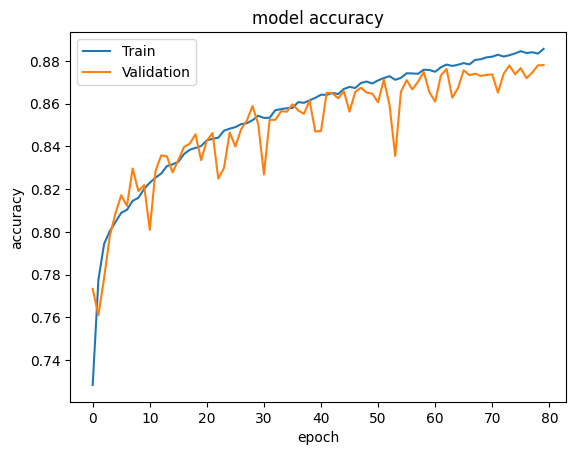

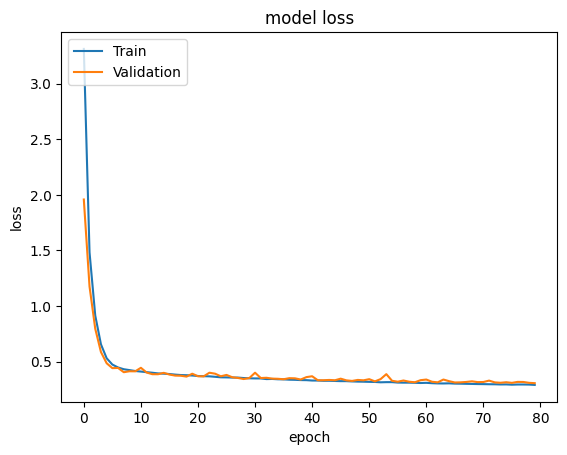

In [25]:
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
y_pred = model3.predict(X_Test)
roc_auc_score(y_Test, y_pred)

1010/1010 [==============================] - 2s 2ms/step


0.8947736394422603

In [27]:
report = classification_report(y_Test, y_pred.round())

In [28]:
print(report)

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     16145
           1       0.85      0.74      0.79     16145

    accuracy                           0.80     32290
   macro avg       0.81      0.80      0.80     32290
weighted avg       0.81      0.80      0.80     32290



Comparing with simple model

In [60]:
model1 = keras.models.load_model('../Model/simple_78_survival.h5')

In [61]:
y_pred = model1.predict(X_Test)
roc_auc_score(y_Test, y_pred)

1010/1010 [==============================] - 2s 2ms/step


0.8800138148770036

In [64]:
print(classification_report(y_Test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.74      0.89      0.80     16145
           1       0.86      0.68      0.76     16145

    accuracy                           0.78     32290
   macro avg       0.80      0.78      0.78     32290
weighted avg       0.80      0.78      0.78     32290



In [29]:
# model3.save('../Model/regularized_80_survival.h5')

In [30]:
model_final = keras.models.load_model('../Model/regularized_80_survival.h5')

## Explainable AI

In [31]:
import shap
shap.initjs()

In [37]:
# Create object that can calculate shap values for deep learning model model_final and on X_Test
explainer = shap.DeepExplainer(model_final, X_Train[:1000].values)

In [38]:
shap_values = explainer.shap_values(X_Test[:1000].values)

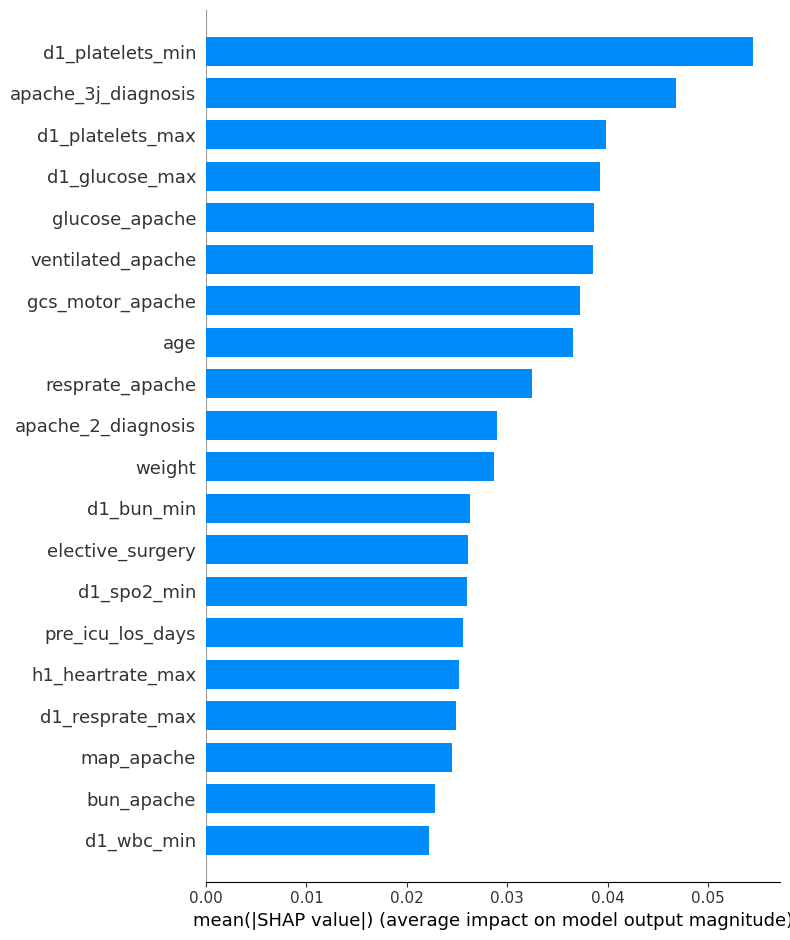

In [74]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names=final_cols, max_display=20)

In [80]:
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][0], feature_names=final_cols)

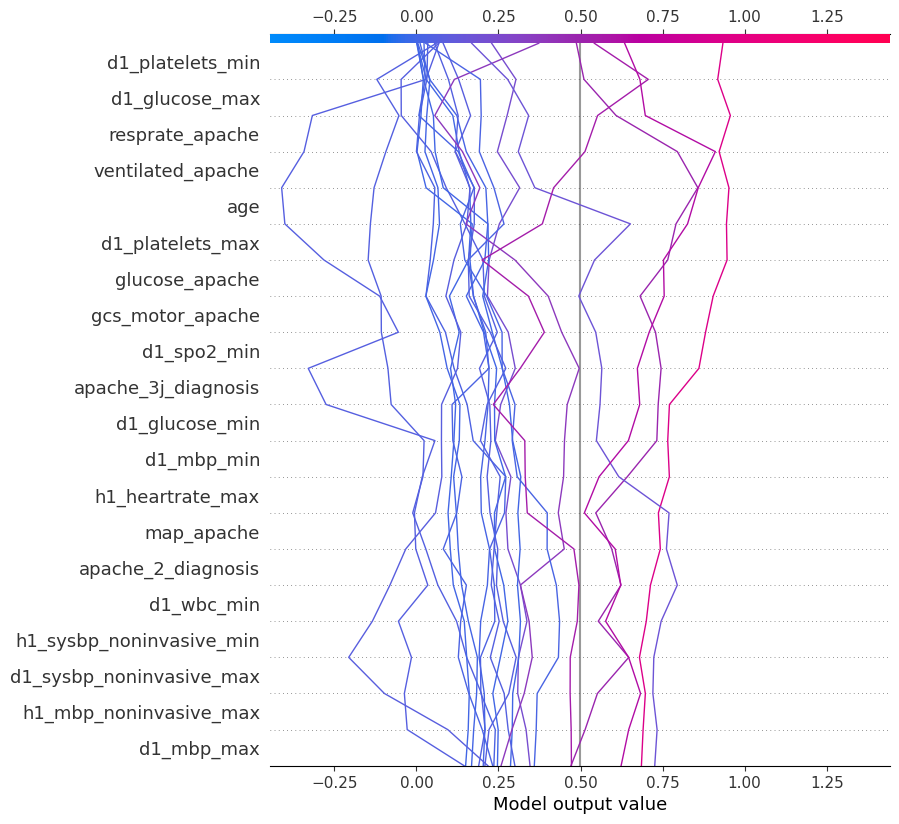

In [82]:
shap.decision_plot(explainer.expected_value[0].numpy(), shap_values[0][10:30], feature_names=final_cols)

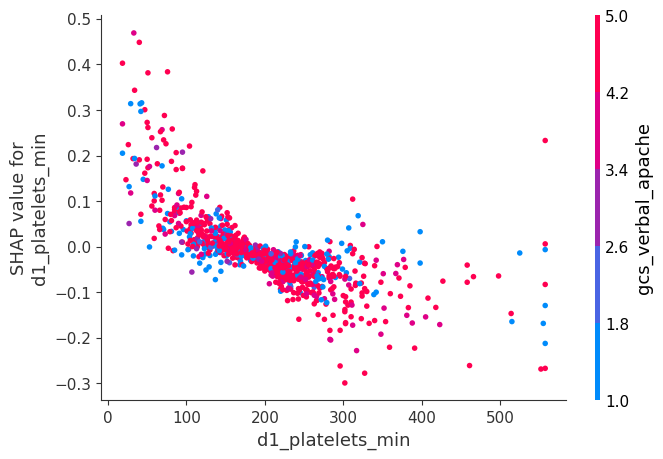

In [84]:
shap.dependence_plot('d1_platelets_min', shap_values[0], X_Test[:1000].values, feature_names=final_cols)

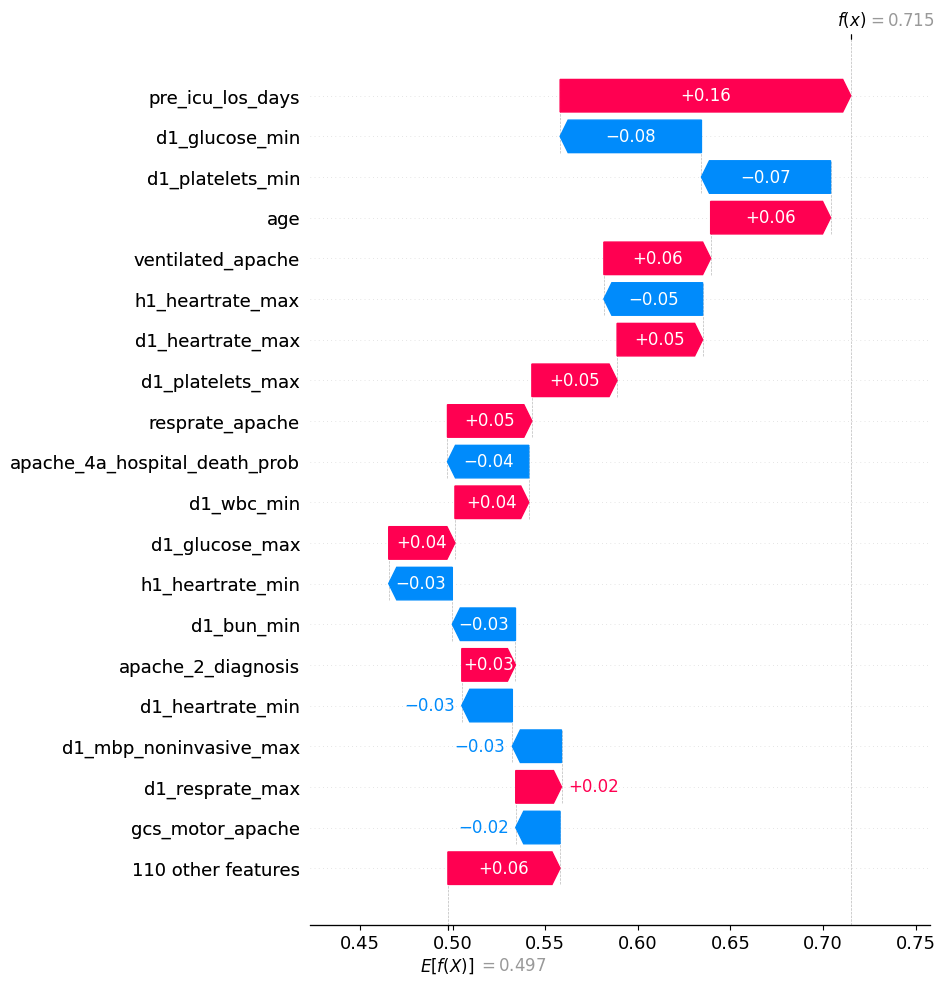

In [91]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][80], feature_names=final_cols, max_display=20)